In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subj_base = 'pipr-sub-003_ses-01_dat-20230705' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

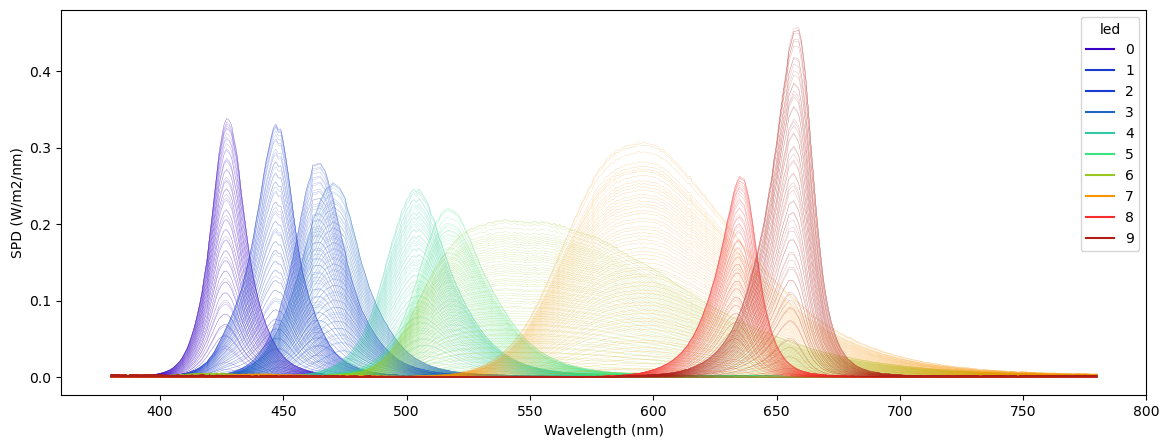

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [5]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [6]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


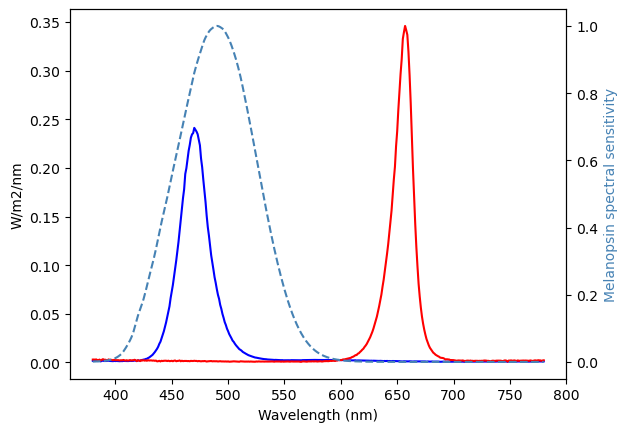

In [7]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [8]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [9]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: n


Please enter subject ID: 003
> Grabbing 750 seconds of pupil.1.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 31031.85642
> Waiting for a light to stamp...
> Light stamped on frame.world at 31158.285079
> Waiting for a light to stamp...
> Light stamped on frame.world at 31284.777037
> Waiting for a light to stamp...
> Light stamped on frame.world at 31411.245427
> Waiting for a light to stamp...
> Light stamped on frame.world at 31537.774172
> Waiting for a light to stamp...
> Light stamped on frame.world at 31664.31662
> PupilGrabber done grabbing 750 seconds of pupil.1.3d


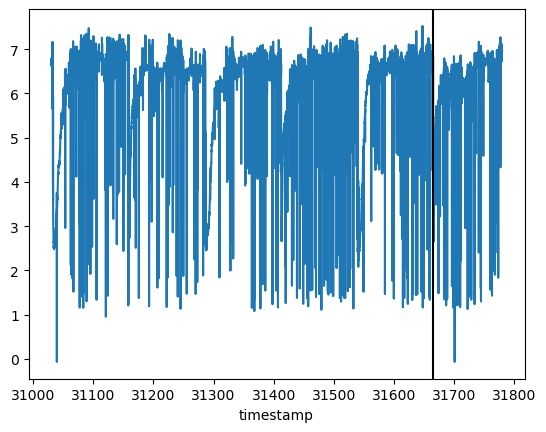

In [10]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials # appropriate offset to account for stim duration + sleeps (removed + 30)


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [11]:
# display data from pandas table
data

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
31029.808715,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2906742644227551, 0.827247724403162]",58.857771,0.947399,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.870814938890307, -7.65969796628...",6.739914,"{'center': [55.809458769168984, 33.16843691459...","[55.809458769168984, 33.1684369145929]",1.0,2.082755,-1.988439
31029.828261,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2905442306334322, 0.8272521009140098]",58.951841,0.987722,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.874244931751161, -7.66038793530...",6.751701,"{'center': [55.78449228161898, 33.167596624510...","[55.78449228161898, 33.16759662451012]",1.0,2.082831,-1.988872
31029.847643,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.29028369596518827, 0.8269042159014677]",58.868258,0.991423,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.87977329570931, -7.651656897754...",6.741131,"{'center': [55.73446962531615, 33.234390546918...","[55.73446962531615, 33.23439054691821]",1.0,2.081868,-1.989300
31029.867860,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.29027428724597937, 0.8268062779739223]",58.875993,0.967081,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.879886237985602, -7.64923100555...",6.741959,"{'center': [55.73266315122804, 33.253194629006...","[55.73266315122804, 33.253194629006934]",1.0,2.081600,-1.989246
31029.874653,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.290192361104775, 0.8267930070511451]",58.952752,0.963970,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.882079778852313, -7.64933234132...",6.751527,"{'center': [55.716933332116795, 33.25574264618...","[55.716933332116795, 33.25574264618013]",1.0,2.081611,-1.989514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31779.720003,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3081028411126084, 0.815088138867019]",60.794467,0.956210,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.4443825010440445, -7.3397808486...",6.945371,"{'center': [59.155745493620806, 35.50307733753...","[59.155745493620806, 35.50307733753234]",1.0,2.047780,-1.930333
31779.744622,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3081681539967232, 0.8147365288471552]",60.868821,1.000000,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.44265568716645, -7.331290549232...",6.954033,"{'center': [59.16828556737085, 35.570586461346...","[59.16828556737085, 35.5705864613462]",1.0,2.046861,-1.929955
31779.767581,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3080676670889034, 0.8142420455510323]",61.006157,1.000000,"{'center': [-1.1960678240172071, -2.5686552563...","{'center': [88.30020116311528, 79.714295137472...","{'center': [-4.444903308549429, -7.31973528632...",6.970461,"{'center': [59.148992081069444, 35.66552725420...","[59.148992081069444, 35.665527254201805]",1.0,2.045610,-1.929973


In [12]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '.csv')

**DATA PROCESSING BEGINS BELOW**

In [13]:
new_data = data[['confidence','id','diameter','diameter_3d']]

In [14]:
samples = new_data
samples

,confidence,id,diameter,diameter_3d
timestamp,,,,
31029.808715,0.947399,1,58.857771,6.739914
31029.828261,0.987722,1,58.951841,6.751701
31029.847643,0.991423,1,58.868258,6.741131
31029.867860,0.967081,1,58.875993,6.741959
31029.874653,0.963970,1,58.952752,6.751527
...,...,...,...,...
31779.720003,0.956210,1,60.794467,6.945371
31779.744622,1.000000,1,60.868821,6.954033
31779.767581,1.000000,1,61.006157,6.970461


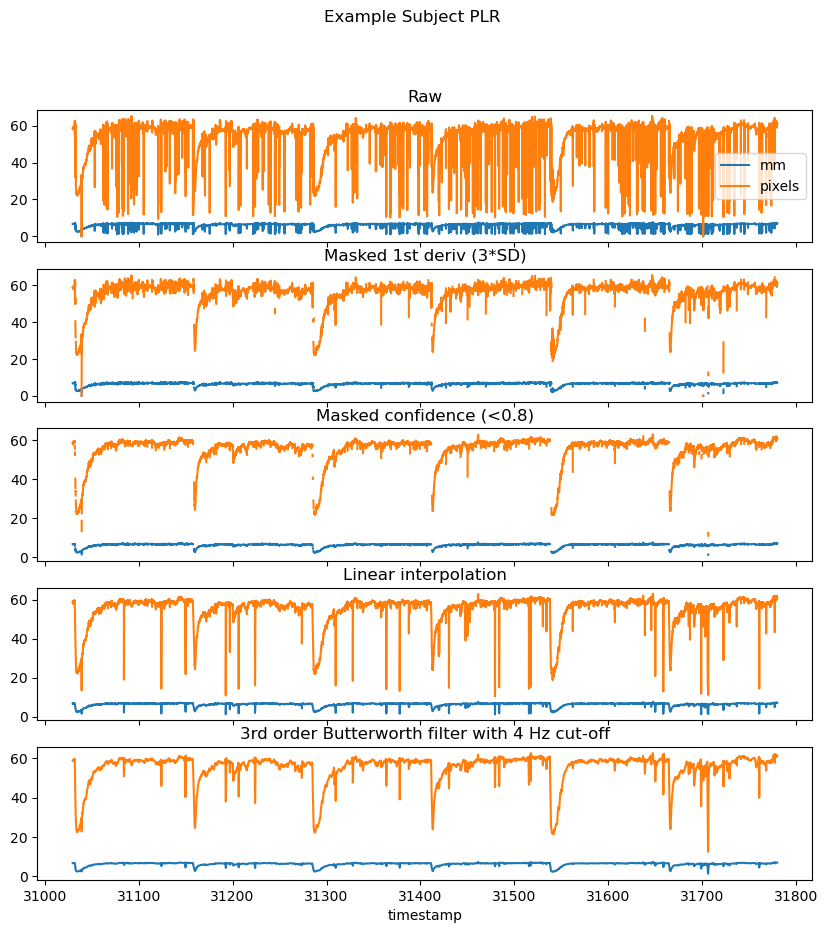

In [15]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [ ]:
# export butterworth processed sample data (?)
data.to_csv(path_base + subj_base + 'butterworth.csv') # raw data
# can stop here if necessary

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
# Read in csv file and extract the column with header "CVR"
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr = pd.read_csv(path_base + subj_base + '.csv')

# Print header names
print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps = df_pipr["timestamp"]
# Extract the column with header "diameter"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi'],
      dtype='object')


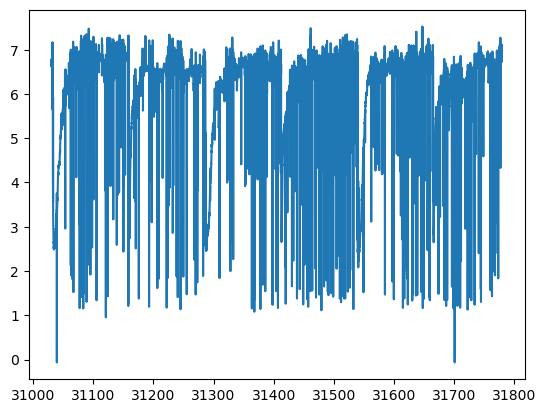

In [18]:
fig = plt.figure()
plt.plot(timestamps, diam_3d)

This is copied from the output of cell 11
> Light stamped on frame.world at 31031.85642
> Waiting for a light to stamp...
> Light stamped on frame.world at 31158.285079
> Waiting for a light to stamp...
> Light stamped on frame.world at 31284.777037
> Waiting for a light to stamp...
> Light stamped on frame.world at 31411.245427
> Waiting for a light to stamp...
> Light stamped on frame.world at 31537.774172
> Waiting for a light to stamp...
> Light stamped on frame.world at 31664.31662

**Edit Cell Below with Timestamps**

In [19]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 31031.85642)[0][-1]
stamp2 = np.where(timestamps <= 31158.285079)[0][-1]
stamp3 = np.where(timestamps <= 31284.777037)[0][-1]
stamp4 = np.where(timestamps <= 31411.245427)[0][-1]
stamp5 = np.where(timestamps <= 31537.774172)[0][-1]
stamp6 = np.where(timestamps <= 31664.31662)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[109, 6118, 12379, 18325, 24058, 29901]

In [20]:
from pyplr import utils
from copy import deepcopy

In [21]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,31029.808715,0.947399,1,58.857771,6.739914
1,31029.828261,0.987722,1,58.951841,6.751701
2,31029.847643,0.991423,1,58.868258,6.741131
3,31029.867860,0.967081,1,58.875993,6.741959
4,31029.874653,0.963970,1,58.952752,6.751527
...,...,...,...,...,...
35351,31779.720003,0.956210,1,60.794467,6.945371
35352,31779.744622,1.000000,1,60.868821,6.954033
35353,31779.767581,1.000000,1,61.006157,6.970461
35354,31779.785069,0.962894,1,60.917922,6.959299


**Extract ranges from samples based on event timing and sample count**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [22]:
samples = df_data
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [23]:
range_idxs

array([   49,  6058, 12319, 18265, 23998, 29841], dtype=int64)

In [24]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [25]:
df.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data**

In [26]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      31030.708884    1.000000   1  58.998465     6.757996        49   
      1      31030.727981    1.000000   1  58.975263     6.755050        50   
      2      31030.747440    1.000000   1  58.809272     6.734276        51   
      3      31030.767370    0.948843   1  58.844050     6.738586        52   
      4      31030.784386    0.986506   1  58.957768     6.753123        53   
...                   ...         ...  ..        ...          ...       ...   
5     3595   31740.247422    1.000000   1  60.943467     6.915795     33436   
      3596   31740.269155    1.000000   1  60.910299     6.911557     33437   
      3597   31740.291308    1.000000   1  60.980077     6.920225     33438   
      3598   31740.312177    1.000000   1  61.026745     6.925608     33439   
      3599   31740.332740    1.000000   1  60.889668     6.908647     33440   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.375211    -0.372642  
      1           -0.418641    -0.411821  
      2           -0.724882    -0.692121  
      3           -0.661346    -0.633393  
      4           -0.447056    -0.441364  
...                     ...          ...  
5     3595         3.146801     3.285235  
      3596         3.083594     3.229024  
      3597         3.212868     3.347281  
      3598         3.293161     3.426372  
      3599         3.040194     3.194059  

[21600 rows x 8 columns]

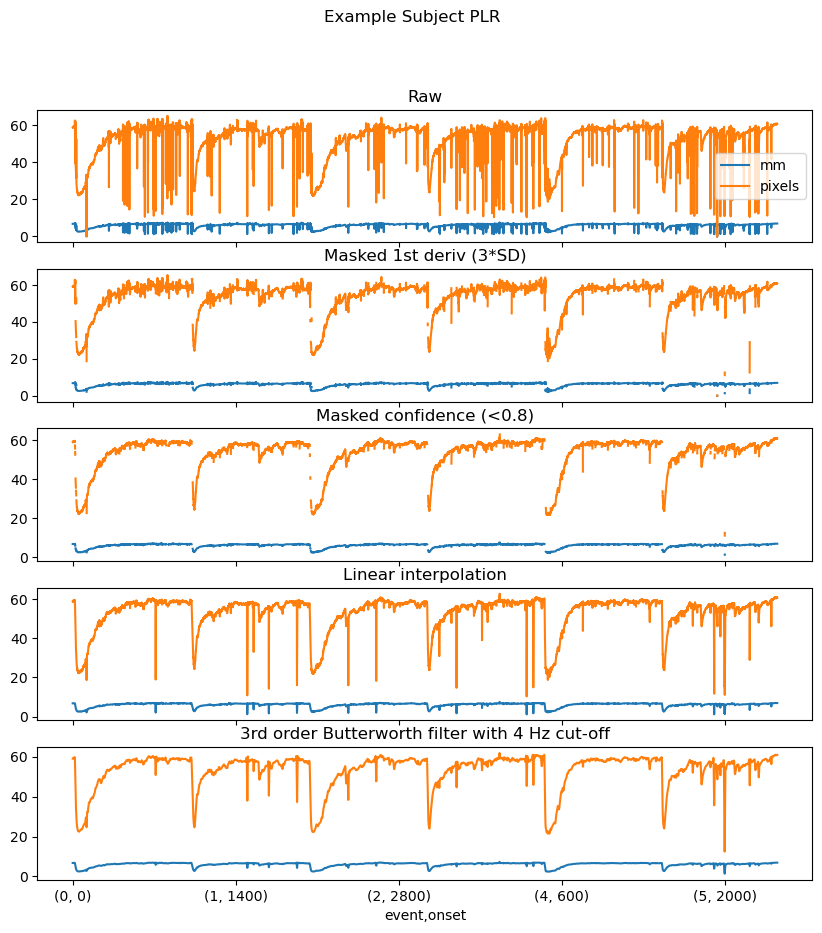

In [27]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples = df

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [28]:
samples # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      31030.708884    1.000000   1  58.981535     6.755894        49   
      1      31030.727981    1.000000   1  58.968803     6.754232        50   
      2      31030.747440    1.000000   1  58.957485     6.752746        51   
      3      31030.767370    0.948843   1  58.948075     6.751501        52   
      4      31030.784386    0.986506   1  58.941024     6.750552        53   
...                   ...         ...  ..        ...          ...       ...   
5     3595   31740.247422    1.000000   1  60.875342     6.907078     33436   
      3596   31740.269155    1.000000   1  60.879203     6.907486     33437   
      3597   31740.291308    1.000000   1  60.882437     6.907824     33438   
      3598   31740.312177    1.000000   1  60.885063     6.908094     33439   
      3599   31740.332740    1.000000   1  60.887136     6.908303     33440   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.375211    -0.372642             0  
      1           -0.418641    -0.411821             0  
      2           -0.724882    -0.692121             0  
      3           -0.661346    -0.633393             0  
      4           -0.447056    -0.441364             0  
...                     ...          ...           ...  
5     3595         3.146801     3.285235             0  
      3596         3.083594     3.229024             0  
      3597         3.212868     3.347281             0  
      3598         3.293161     3.426372             0  
      3599         3.040194     3.194059             0  

[21600 rows x 9 columns]

In [29]:
df

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0      31030.708884    1.000000   1  58.998465     6.757996        49   
      1      31030.727981    1.000000   1  58.975263     6.755050        50   
      2      31030.747440    1.000000   1  58.809272     6.734276        51   
      3      31030.767370    0.948843   1  58.844050     6.738586        52   
      4      31030.784386    0.986506   1  58.957768     6.753123        53   
...                   ...         ...  ..        ...          ...       ...   
5     3595   31740.247422    1.000000   1  60.943467     6.915795     33436   
      3596   31740.269155    1.000000   1  60.910299     6.911557     33437   
      3597   31740.291308    1.000000   1  60.980077     6.920225     33438   
      3598   31740.312177    1.000000   1  61.026745     6.925608     33439   
      3599   31740.332740    1.000000   1  60.889668     6.908647     33440   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.375211    -0.372642  
      1           -0.418641    -0.411821  
      2           -0.724882    -0.692121  
      3           -0.661346    -0.633393  
      4           -0.447056    -0.441364  
...                     ...          ...  
5     3595         3.146801     3.285235  
      3596         3.083594     3.229024  
      3597         3.212868     3.347281  
      3598         3.293161     3.426372  
      3599         3.040194     3.194059  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [30]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df.index = df.index.set_levels(
    levels=new_onset, level='onset')

In [31]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc'],
      dtype='object')

In [32]:
df["colour"] = ""

In [33]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc', 'colour'],
      dtype='object')

In [34]:
for (event, onset) in df.index:
    if event%2==1:
        df["colour"][event,onset] = "red"
    else:
        df["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\884742854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\884742854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 1')

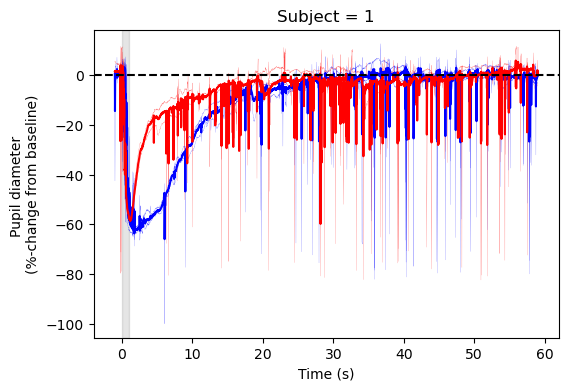

In [35]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs = (df.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

In [36]:
df # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000   31030.708884    1.000000   1  58.998465     6.757996   
      -0.983333   31030.727981    1.000000   1  58.975263     6.755050   
      -0.966667   31030.747440    1.000000   1  58.809272     6.734276   
      -0.950000   31030.767370    0.948843   1  58.844050     6.738586   
      -0.933333   31030.784386    0.986506   1  58.957768     6.753123   
...                        ...         ...  ..        ...          ...   
5      58.916667  31740.247422    1.000000   1  60.943467     6.915795   
       58.933333  31740.269155    1.000000   1  60.910299     6.911557   
       58.950000  31740.291308    1.000000   1  60.980077     6.920225   
       58.966667  31740.312177    1.000000   1  61.026745     6.925608   
       58.983333  31740.332740    1.000000   1  60.889668     6.908647   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         49       -0.375211    -0.372642   blue  
      -0.983333         50       -0.418641    -0.411821   blue  
      -0.966667         51       -0.724882    -0.692121   blue  
      -0.950000         52       -0.661346    -0.633393   blue  
      -0.933333         53       -0.447056    -0.441364   blue  
...                    ...             ...          ...    ...  
5      58.916667     33436        3.146801     3.285235    red  
       58.933333     33437        3.083594     3.229024    red  
       58.950000     33438        3.212868     3.347281    red  
       58.966667     33439        3.293161     3.426372    red  
       58.983333     33440        3.040194     3.194059    red  

[21600 rows x 9 columns]

In [37]:
df.to_csv(path_base + subj_base + '-processed.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

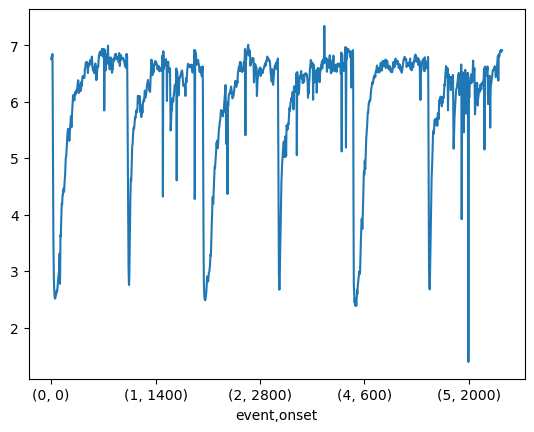

In [38]:
samples["diameter_3d"].plot()

**Compute the pupillary light response:**

In [39]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\763502945.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_33060\763502945.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  average_plr = df.mean(level=1)['diameter_3d'].to_numpy()


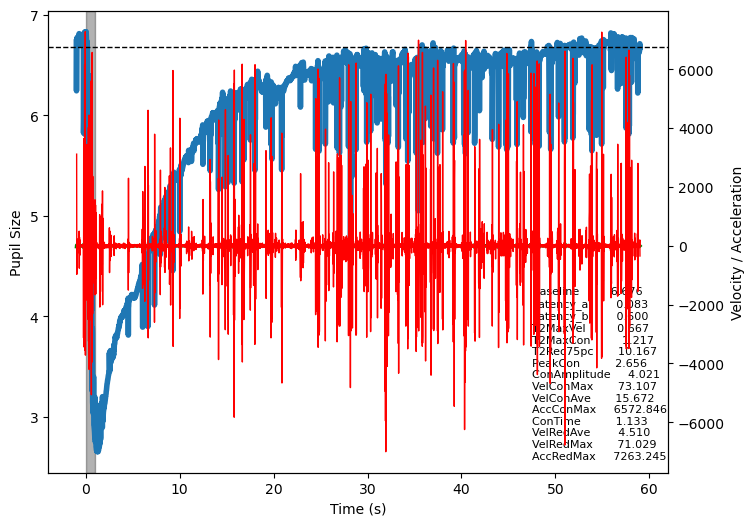

In [40]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [41]:
params = plr.parameters()
params

,value
Baseline,6.676223
Latency_a,0.083333
Latency_b,0.600000
T2MaxVel,0.666667
T2MaxCon,1.216667
T2Rec75pc,10.166667
PeakCon,2.655701
ConAmplitude,4.020522
VelConMax,73.106794
VelConAve,15.671550


In [ ]:
avgs.to_csv(path_base + subj_base + '-average-pipr.csv') # processed data with adjusted onset indices (time in seconds)

In [ ]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
avgs.loc[avgs["onset"] == pipr_time]

In [ ]:
blue_d_pipr = avgs["diameter_3d"][480]
red_d_pipr = avgs["diameter_3d"][4080]
blue_d_pipr_pc = avgs["diameter_3d_pc"][480]
red_d_pipr_pc = avgs["diameter_3d_pc"][4080]
pipr_diff = red_d_pipr - blue_d_pipr
pipr_pc_diff = red_d_pipr_pc - blue_d_pipr_pc